In [ ]:
from google.colab import drive
# // 挂载谷歌云盘
drive.mount('/content/gdrive')
# // 设置工作路径
import os
os.chdir('/content/gdrive/MyDrive/Colab Notebooks/MSC Project/')

Mounted at /content/gdrive


In [ ]:
!pip install mne
!pip install pyedflib
!pip install pywt
!pip install keras
!pip install tensorflow
!pip install matplotlib

import os
import numpy as np
import pandas as pd
import mne
import pywt
import matplotlib
import matplotlib.pyplot as plt
from mne.io import RawArray, read_raw_edf
from mne.io import concatenate_raws as  mne
from scipy import signal
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from google.colab import drive
from PIL import Image
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, LSTM
from keras.preprocessing import image
from tensorflow.keras.preprocessing import image
from keras.utils import to_categorical
import tensorflow as tf

from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping

from keras.layers import Reshape
from tensorflow.keras.layers import LSTM, Dense, Flatten
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0,EfficientNetB1
from tensorflow.keras.applications import DenseNet121,DenseNet169,DenseNet201
from tensorflow.keras.applications import InceptionV3
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.xception import Xception
from keras.applications.nasnet import NASNetLarge, NASNetMobile
from tensorflow.keras.applications import ResNet50,ResNet101,ResNet152
from tensorflow.keras.applications import MobileNet,MobileNetV2
from keras.applications import VGG16,VGG19

# images path
healthy_save_path = '/content/gdrive/MyDrive/Colab Notebooks/MSC Project/healthy25-new'
schizophrenia_save_path = '/content/gdrive/MyDrive/Colab Notebooks/MSC Project/schizophrenia25-new'


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 6.1 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement pywt (from versions: none)
ERROR: No matching distribution found for pywt


数据预处理：EEG信号的处理与绘制小波时频图

Data preprocessing: EEG signal processing and drawing wavelet time-frequency diagram

In [ ]:

# 定义EDF文件列表
# Load the list of EDF files
h_files=['h01.edf', 'h02.edf', 'h03.edf', 'h04.edf', 'h05.edf', 'h06.edf', 'h07.edf', 'h08.edf', 'h09.edf', 'h10.edf', 'h11.edf', 'h12.edf', 'h13.edf', 'h14.edf']
s_files = ['s01.edf', 's02.edf', 's03.edf', 's04.edf', 's05.edf', 's06.edf', 's07.edf', 's08.edf', 's09.edf', 's10.edf', 's11.edf', 's12.edf', 's13.edf', 's14.edf']
edf_files = s_files+h_files

print(edf_files)

# 定义通道列表和其他参数
# Define channel list
channels = ["Fp1", "Fp2", "F7", "F3", "Fz", "F4", "F8", "T3", "C3", "Cz",
"C4", "T4", "T5", "P3", "Pz", "P4", "T6", "O1", "O2"]

# 定义时间窗口大小和重叠大小
# Define time window size and overlap size in seconds
# Split the data into time windows of fixed length 25 seconds
window_size = 25 # 秒为单位 将数据分割为固定长度为 25 秒的时间窗口
# No data overlap between adjacent time windows
overlap_size = 0 # 秒为单位 相邻时间窗口之间无数据重叠
# Reduce the sample rate to 250 Hz
resample_rate = 250  # 将采样率降低为 250 Hz

# 存储所有图片的特征值和标签
# Store feature values and labels for all images
X_features = []
y_labels = []
# 统计小波时频图数量
total_wavelet_plots = 0

# 初始化保存图片文件夹
# 使用os.listdir()获取文件列表并删除文件
# Initialize save image folder
def delete_files_in_folder(folder_path):
    file_list = os.listdir(folder_path)
    for file in file_list:
        file_path = os.path.join(folder_path, file)
        os.remove(file_path)

# 删除第一个文件夹中的文件
delete_files_in_folder(healthy_save_path)

# 删除第二个文件夹中的文件
delete_files_in_folder(schizophrenia_save_path)

print("两个文件夹中的所有文件已成功删除。")


# 读取每个EDF文件并处理
for edf_file in edf_files:
    # 1. 加载EDF文件
    raw = mne.io.read_raw_edf(edf_file, preload=True)

    # 2. 去除噪声和伪差异（可以根据需要添加其他去噪方法，如ICA等）
    # Remove noise and false differences (other denoising methods can be added as needed, such as ICA, etc.)
    raw.notch_filter([50, 60], fir_design='firwin')  # 去除电源线噪声

    # 3.创建 ICA 对象 - Create ICA object
    ica = mne.preprocessing.ICA(n_components=19, random_state=97, max_iter=800)
    ica.fit(raw)

    # 将 ICA 去除的成分应用到数据中 - Apply the components removed by ICA to the data
    ica.apply(raw)

    # 4. 选择感兴趣的通道 - Select the channel of interest
    raw.pick_channels(channels)

    # 5. 滤波 - Filtering
    low_freq = 1  # 低频截止频率 （Delta Waves和Theta Waves）
    high_freq = 30  # 高频截止频率（Alpha Waves、Beta Waves和Gamma Waves）
    raw.filter(low_freq, high_freq)

    # 6. 重参考到平均参考 - Re-reference to average reference
    raw.set_eeg_reference('average', projection=True)

    # # 7. 去基线校正（Baseline Correction）
    # raw.apply_baseline(baseline=(None, 0))  # 将整个数据的平均值置为零

    # 8. 降采样 - Downsampling
    raw.resample(resample_rate)

    # 获取滤波后的信号数据 - Get filtered signal data
    data, times = raw[:]

    # 进行小波变换
    # wavelet = 'db6'  # 小波类型
    # level = 6  # 分解级别，用于小波变换的层数
    # coeffs = pywt.wavedec(data, wavelet, level=level, axis=1)

    wavelet = 'morl'  # Choose a wavelet for CWT
    scales = np.arange(1, 11)  # Define the scales for CWT

    # 连续小波变换 (CWT) - Perform Continuous Wavelet Transform (CWT)
    coeffs, frequencies = pywt.cwt(data, scales, wavelet)

    # 计算小波系数能量
    # Compute wavelet coefficient energy
    energy = []
    for j in range(len(coeffs)):
        energy.append(np.sum(np.abs(coeffs[j])**2, axis=0))

    # 调整能量数组的长度
    max_length = max(len(energy_level) for energy_level in energy)
    for j in range(len(energy)):
        padding = max_length - len(energy[j])
        energy[j] = np.pad(energy[j], (0, padding), 'constant')

    # 归一化能量值
    # normalized energy value
    scaler = MinMaxScaler()
    energy_normalized = scaler.fit_transform(np.vstack(energy).T).T

    # 对能量值应用对数缩放
    # apply logarithmic scaling to energy values
    log_energy = np.log10(energy_normalized + 1)

    # 将能量值按时间窗口大小进行分割
    # Divide the energy value according to the size of the time window
    sampling_rate = raw.info['sfreq']
    window_size_samples = int(window_size * sampling_rate)
    num_windows = (log_energy.shape[1] - window_size_samples) // window_size_samples + 1

    # 存储每个时间窗口的小波时频图
    # Store the wavelet time-frequency map of each time window
    wavelet_time_freq_plots = []

    for i in range(num_windows):
        start_sample = i * window_size_samples
        end_sample = start_sample + window_size_samples

        # 提取当前时间窗口的能量值
        # Extract the energy value of the current time window
        window_energy = log_energy[:, start_sample:end_sample]

        # 添加小波时频图到列表
        wavelet_time_freq_plots.append(window_energy)

    # 将小波时频图列表转换为numpy数组
    # Convert the list of wavelet time-frequency plots to numpy arrays
    wavelet_time_freq_plots = np.array(wavelet_time_freq_plots)

    # 获取时间轴和频率轴
    # Get time axis and frequency axis
    time_axis = np.arange(wavelet_time_freq_plots.shape[1]) * window_size
    freq_axis = np.arange(wavelet_time_freq_plots.shape[2]) * (sampling_rate / (2 * wavelet_time_freq_plots.shape[2]))
    # print("time_axis: ",time_axis.shape)
    # print("freq_axis: ",freq_axis.shape)

    # 计算每个时间窗口的起始和结束索引
    # Calculate the start and end index of each time window
    sampling_rate = raw.info['sfreq']
    window_size_samples = int(window_size * sampling_rate)
    overlap_size_samples = int(overlap_size * sampling_rate)
    start_indexes = np.arange(0, log_energy.shape[1] - window_size_samples + 1, window_size_samples - overlap_size_samples)
    end_indexes = start_indexes + window_size_samples

    total_file_wavelet_plots = 0
    # 遍历每个时间窗口的小波时频图并绘制
    # Traverse the wavelet time-frequency graph of each time window and draw
    for i in range(wavelet_time_freq_plots.shape[0]):
        plt.figure(figsize=(10, 6))

        # 获取当前时间窗口的小波时频图数据
        current_window_data = wavelet_time_freq_plots[i]

        # 生成时间轴和频率轴的坐标
        time_axis_window = np.linspace(time_axis[0], time_axis[-1], current_window_data.shape[0])
        freq_axis_window = np.linspace(freq_axis[0], freq_axis[-1], current_window_data.shape[1])
        plt.imshow(current_window_data, aspect='auto', cmap='jet', extent=[time_axis_window[0], time_axis_window[-1], freq_axis_window[0], freq_axis_window[-1]])

        # 用于CNN的图像提取特征值不需要展示xy轴坐标和colorbar
        # Image extraction feature values for CNN do not need to display xy axis coordinates and colorbar
        # plt.xlabel('Time (s)')
        # plt.ylabel('Frequency')
        # plt.title(f'Wavelet Time-Frequency Plot - Window {i+1} - {edf_file}')
        # plt.colorbar()
        plt.axis('off')  # 不显示xy轴坐标

        # 设置保存路径和图片文件
        # Set the save path and image file
        save_path = ''
        prefix = os.path.basename(edf_file)[:1]
        print(prefix)
        if prefix == 'h':
            save_path = healthy_save_path
        if prefix == 's':
            save_path = schizophrenia_save_path
        file_name = f'{edf_file.split(".")[0]} - Window{i+1}.png'
        # 保存图像
        plt.savefig(f'{save_path}/{file_name}')

        plt.show()
        # 关闭当前绘图，释放内存
        plt.close()

        # 判断edf_file是属于healthy还是schizophrenia，然后添加对应的标签
        # Determine whether the edf_file belongs to healthy(0) or schizophrenia(1), and then add the corresponding label
        if edf_file.startswith('h'):
            y_labels.append(0)  # 健康标签为0
        else:
            y_labels.append(1)  # 精神分裂症标签为1
        total_file_wavelet_plots+=1

    total_wavelet_plots+=total_file_wavelet_plots
    # print(f"{edf_file} Wavelet Time-Frequency Plot count：{total_file_wavelet_plots}")
print(f"Total Wavelet Time-Frequency Plot count：{total_wavelet_plots}")



# 加载处理后的小波时频图图片数据集
# Load the processed wavelet time-frequency image dataset

In [ ]:
# 定义“healthy”和“schizophrenia”文件夹路径
healthy_folder = healthy_save_path
schizophrenia_folder = schizophrenia_save_path

# 定义函数用于加载和处理图像
# Define functions for loading and processing images
def load_images(folder):
    images = []
    labels = []
    for filename in os.listdir(folder):
        if filename.endswith(".png"):
            img =image.load_img(os.path.join(folder, filename), target_size=(128, 128))
            img_array = image.img_to_array(img) / 255.0  # 将像素值归一化到[0, 1]
            images.append(img_array)
            labels.append(0 if folder == healthy_folder else 1)
    return np.array(images), np.array(labels)

# 加载和处理图像
X_healthy, y_healthy = load_images(healthy_folder)
X_schizophrenia, y_schizophrenia = load_images(schizophrenia_folder)

# 将数据集合并
# Merge datasets
X = np.concatenate((X_healthy, X_schizophrenia), axis=0)
y = np.concatenate((y_healthy, y_schizophrenia), axis=0)

# 打乱数据集
# Shuffle the dataset
indices = np.arange(X.shape[0])
np.random.shuffle(indices)
X = X[indices]
y = y[indices]
print('X Shape: ', X.shape)


X Shape:  (1142, 128, 128, 3)


# 使用随机搜索和交叉验证的方法寻找基于深度迁移学习的CNN模型的最佳参数

# Use random search and cross-validation methods to find the best parameters of the CNN model based on deep transfer learning

In [ ]:
import time
from keras.layers import Reshape
from keras.optimizers import Adam, RMSprop, SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint

# 总结：

# MobileNet epochs=100, batch_size=128
# Test accuracy:  0.8600583076477051

# InceptionResNetV2 epochs=50, batch_size=64
# Test accuracy:  0.8483964800834656

# InceptionV3 epochs=50, batch_size=64
# Test accuracy:  0.8367347121238708

start_time = time.time()

# 划分训练集和测试集
# Divide training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

def create_model(optimizer='adam',activation='sigmoid',units=128, dropout=0.2,
                 recurrent_dropout=0.2,learning_rate=0.001,epochs=20, batch_size=64):
    # 原始数据集的形状
    input_shape = (128, 128, 3)
    # 加载基于迁移学习的CNN预训练模型
    # Load the CNN pre-training model based on transfer learning
    base_model = MobileNet(weights='imagenet', include_top=False, input_shape=input_shape)
    # base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    # base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
    # base_model = DenseNet169(weights='imagenet', include_top=False, input_shape=input_shape)


    # base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    # base_model = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)
    # base_model = MobileNet(weights='imagenet', include_top=False, input_shape=input_shape)
    # base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    # base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    # base_model = ResNet101(weights='imagenet', include_top=False, input_shape=input_shape)
    # base_model = ResNet152(weights='imagenet', include_top=False, input_shape=input_shape)
    # base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)
    # base_model = DenseNet169(weights='imagenet', include_top=False, input_shape=input_shape)
    # base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=input_shape)
    # base_model = Xception(weights='imagenet', include_top=False, input_shape=input_shape)
    # base_model = NASNetLarge(weights='imagenet', include_top=False, input_shape=input_shape)
    # base_model = NASNetMobile(weights='imagenet', include_top=False, input_shape=input_shape)

    # 设定不更新预训练模型的权重
    #Do not update the weights of the pre-trained model
    for layer in base_model.layers:
        layer.trainable = False

    # 获取base_model的输出，然后添加新的层
    base_model_output = base_model.output

    # 获取模型最后一层的输出形状
    output_shape = base_model.output_shape
    print('Output Shape: ', output_shape)

    # 输出形状是一个形状元组，其形式为 (None, height, width, depth)
    # 其中 height, width, depth 是特征图的高度，宽度和深度（也就是特征的数量）
    # 这里我们只关心深度，因为它是我们要传入 LSTM 的特征数量
    # Here we only care about depth as it is the number of features we are going to pass into LSTM
    features_dim = output_shape[-1]  # 提取深度维度
    print('Features Dimension: ', features_dim)

    # 添加Reshape层
    # 我们可以使用从 base_model 获取的 features_dim 来重新塑造特征
    # reshape features
    x = Reshape((-1, features_dim))(base_model_output)
    print('Reshape : ', x)

    # 添加LSTM层
    # Add LSTM layer
    x = LSTM(units, dropout=dropout, recurrent_dropout=recurrent_dropout)(x)
    x = Dense(1, activation='sigmoid')(x)

    # 构建最终模型
    # Build the final model
    model = Model(inputs=base_model.input, outputs=x)

    if optimizer == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        optimizer = SGD(learning_rate=learning_rate)

    # 编译模型
    # Compile the model
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    # 创建早停回调
    # create early stop callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

    # 创建模型检查点回调
    # create model checkpoint callback
    model_checkpoint = ModelCheckpoint('MobileNet_Random_Best_Model.h5', monitor='val_loss', save_best_only=True)

    # # 训练模型
    # 在模型训练过程中添加这两个回调
    # Train the model
    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, callbacks=[early_stopping, model_checkpoint])

    return model


# 定义LSTM模型为KerasClassifier，并传递新函数
lstm_model = KerasClassifier(build_fn=create_model, epochs=20, batch_size=64, verbose=0)

# 定义LSTM模型的超参数搜索空间
# Define the hyperparameter search space of the LSTM model
lstm_param_dist = {
    'units': [128],
    'recurrent_dropout': [0.2],
    'epochs': [100],
    'dropout': [0.2],
    'batch_size': [128],
    'activation': ['sigmoid'],
    'optimizer': ['adam', 'rmsprop', 'sgd'],
    'learning_rate': [0.001, 0.01] # 添加学习率作为超参数
    }


# 定义k折交叉验证
# k-fold cross-validation
kfold = StratifiedKFold(n_splits=5, shuffle=True)

# 使用随机搜索进行LSTM模型参数调优
# Use random search for LSTM model parameter tuning
random_search_lstm = RandomizedSearchCV(lstm_model, param_distributions=lstm_param_dist, n_iter=10, cv=kfold, verbose=2)
random_search_lstm.fit(X_train, y_train)

# 输出LSTM模型的最佳参数和得分
# Output the best parameters and scores of the LSTM model
print("Best LSTM parameters: ", random_search_lstm.best_params_)
print("Best LSTM accuracy: ", random_search_lstm.best_score_)
random_search_lstm.best_estimator_.model.save('MobileNet_Best_Model.h5')

# Best LSTM parameters:  {'units': 128, 'recurrent_dropout': 0.2, 'optimizer': 'rmsprop', 'learning_rate': 0.001, 'epochs': 100, 'dropout': 0.2, 'batch_size': 128, 'activation': 'sigmoid'}
# Best LSTM accuracy:  0.9111084938049316


<ipython-input-4-5c9dc8f3cb26>:91: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = KerasClassifier(build_fn=create_model, epochs=20, batch_size=64, verbose=0)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 6 candidates, totalling 30 fits
17225924/17225924 [==============================] - 0s 0us/step
Output Shape:  (None, 4, 4, 1024)
Features Dimension:  1024
Reshape :  KerasTensor(type_spec=TensorSpec(shape=(None, 16, 1024), dtype=tf.float32, name=None), name='reshape/Reshape:0', description="created by layer 'reshape'")


Epoch 1/100
7/7 [==============================] - 16s 479ms/step - loss: 0.7618 - accuracy: 0.4944 - val_loss: 0.6934 - val_accuracy: 0.4840
Epoch 2/100
7/7 [==============================] - 1s 193ms/step - loss: 0.6687 - accuracy: 0.5632 - val_loss: 0.6658 - val_accuracy: 0.5598
Epoch 3/100
7/7 [==============================] - 2s 272ms/step - loss: 0.6442 - accuracy: 0.6358 - val_loss: 0.6298 - val_accuracy: 0.6676
Epoch 4/100
7/7 [==============================] - 2s 275ms/step - loss: 0.6122 - accuracy: 0.6796 - val_loss: 0.6091 - val_accuracy: 0.6560
Epoch 5/100
7/7 [==============================] - 2s 244ms/step - loss: 0.5851 - accuracy: 0.6859 - val_loss: 0.5978 - val_accuracy: 0.6735
Epoch 6/100
7/7 [==============================] - 1s 179ms/step - loss: 0.5460 - accuracy: 0.7222 - val_loss: 0.5701 - val_accuracy: 0.6910
Epoch 7/100
7/7 [==============================] - 1s 199ms/step - loss: 0.5187 - accuracy: 0.7297 - val_loss: 0.5421 - val_accuracy: 0.7055
Epoch 8/100


Output Shape:  (None, 4, 4, 1024)
Features Dimension:  1024
Reshape :  KerasTensor(type_spec=TensorSpec(shape=(None, 16, 1024), dtype=tf.float32, name=None), name='reshape_1/Reshape:0', description="created by layer 'reshape_1'")
Epoch 1/100
7/7 [==============================] - 8s 520ms/step - loss: 0.7261 - accuracy: 0.5131 - val_loss: 0.6717 - val_accuracy: 0.5831
Epoch 2/100
7/7 [==============================] - 1s 174ms/step - loss: 0.6547 - accuracy: 0.6133 - val_loss: 0.6350 - val_accuracy: 0.6706
Epoch 3/100
7/7 [==============================] - 1s 178ms/step - loss: 0.6201 - accuracy: 0.6746 - val_loss: 0.6015 - val_accuracy: 0.6968
Epoch 4/100
7/7 [==============================] - 1s 178ms/step - loss: 0.5802 - accuracy: 0.7184 - val_loss: 0.5934 - val_accuracy: 0.6793
Epoch 5/100
7/7 [==============================] - 1s 169ms/step - loss: 0.5471 - accuracy: 0.7121 - val_loss: 0.5687 - val_accuracy: 0.7055
Epoch 6/100
7/7 [==============================] - 1s 121ms/step 

Output Shape:  (None, 4, 4, 1024)
Features Dimension:  1024
Reshape :  KerasTensor(type_spec=TensorSpec(shape=(None, 16, 1024), dtype=tf.float32, name=None), name='reshape_2/Reshape:0', description="created by layer 'reshape_2'")
Epoch 1/100
7/7 [==============================] - 7s 465ms/step - loss: 0.7582 - accuracy: 0.4781 - val_loss: 0.6757 - val_accuracy: 0.6064
Epoch 2/100
7/7 [==============================] - 1s 182ms/step - loss: 0.6682 - accuracy: 0.5895 - val_loss: 0.6510 - val_accuracy: 0.6443
Epoch 3/100
7/7 [==============================] - 1s 172ms/step - loss: 0.6440 - accuracy: 0.6333 - val_loss: 0.6338 - val_accuracy: 0.6472
Epoch 4/100
7/7 [==============================] - 1s 170ms/step - loss: 0.6147 - accuracy: 0.6771 - val_loss: 0.6252 - val_accuracy: 0.6531
Epoch 5/100
7/7 [==============================] - 2s 254ms/step - loss: 0.5872 - accuracy: 0.7109 - val_loss: 0.5963 - val_accuracy: 0.6939
Epoch 6/100
7/7 [==============================] - 2s 249ms/step 

Output Shape:  (None, 4, 4, 1024)
Features Dimension:  1024
Reshape :  KerasTensor(type_spec=TensorSpec(shape=(None, 16, 1024), dtype=tf.float32, name=None), name='reshape_3/Reshape:0', description="created by layer 'reshape_3'")
Epoch 1/100
7/7 [==============================] - 6s 404ms/step - loss: 0.6794 - accuracy: 0.5870 - val_loss: 0.6504 - val_accuracy: 0.5948
Epoch 2/100
7/7 [==============================] - 2s 273ms/step - loss: 0.6283 - accuracy: 0.6220 - val_loss: 0.5980 - val_accuracy: 0.6647
Epoch 3/100
7/7 [==============================] - 2s 276ms/step - loss: 0.5921 - accuracy: 0.6783 - val_loss: 0.5900 - val_accuracy: 0.6910
Epoch 4/100
7/7 [==============================] - 2s 238ms/step - loss: 0.5686 - accuracy: 0.6921 - val_loss: 0.5609 - val_accuracy: 0.7026
Epoch 5/100
7/7 [==============================] - 1s 172ms/step - loss: 0.5073 - accuracy: 0.7509 - val_loss: 0.5539 - val_accuracy: 0.6910
Epoch 6/100
7/7 [==============================] - 1s 178ms/step 

Output Shape:  (None, 4, 4, 1024)
Features Dimension:  1024
Reshape :  KerasTensor(type_spec=TensorSpec(shape=(None, 16, 1024), dtype=tf.float32, name=None), name='reshape_4/Reshape:0', description="created by layer 'reshape_4'")
Epoch 1/100
7/7 [==============================] - 8s 434ms/step - loss: 0.7505 - accuracy: 0.4956 - val_loss: 0.6720 - val_accuracy: 0.6385
Epoch 2/100
7/7 [==============================] - 1s 199ms/step - loss: 0.6696 - accuracy: 0.5645 - val_loss: 0.6486 - val_accuracy: 0.6210
Epoch 3/100
7/7 [==============================] - 1s 174ms/step - loss: 0.6502 - accuracy: 0.6320 - val_loss: 0.6320 - val_accuracy: 0.6385
Epoch 4/100
7/7 [==============================] - 1s 169ms/step - loss: 0.6087 - accuracy: 0.6696 - val_loss: 0.6036 - val_accuracy: 0.6793
Epoch 5/100
7/7 [==============================] - 1s 170ms/step - loss: 0.5787 - accuracy: 0.7009 - val_loss: 0.5867 - val_accuracy: 0.6997
Epoch 6/100
7/7 [==============================] - 1s 170ms/step 

Output Shape:  (None, 4, 4, 1024)
Features Dimension:  1024
Reshape :  KerasTensor(type_spec=TensorSpec(shape=(None, 16, 1024), dtype=tf.float32, name=None), name='reshape_5/Reshape:0', description="created by layer 'reshape_5'")
Epoch 1/100
7/7 [==============================] - 7s 377ms/step - loss: 0.8484 - accuracy: 0.5432 - val_loss: 0.6960 - val_accuracy: 0.5219
Epoch 2/100
7/7 [==============================] - 1s 174ms/step - loss: 0.6721 - accuracy: 0.5807 - val_loss: 0.7318 - val_accuracy: 0.5598
Epoch 3/100
7/7 [==============================] - 2s 226ms/step - loss: 0.6605 - accuracy: 0.5957 - val_loss: 0.8120 - val_accuracy: 0.4431
Epoch 4/100
7/7 [==============================] - 2s 253ms/step - loss: 0.6400 - accuracy: 0.6320 - val_loss: 0.6188 - val_accuracy: 0.6356
Epoch 5/100
7/7 [==============================] - 1s 214ms/step - loss: 0.5931 - accuracy: 0.6771 - val_loss: 0.5883 - val_accuracy: 0.6939
Epoch 6/100
7/7 [==============================] - 1s 176ms/step 

Output Shape:  (None, 4, 4, 1024)
Features Dimension:  1024
Reshape :  KerasTensor(type_spec=TensorSpec(shape=(None, 16, 1024), dtype=tf.float32, name=None), name='reshape_6/Reshape:0', description="created by layer 'reshape_6'")
Epoch 1/100
7/7 [==============================] - 7s 406ms/step - loss: 0.8267 - accuracy: 0.5307 - val_loss: 0.6863 - val_accuracy: 0.5248
Epoch 2/100
7/7 [==============================] - 1s 169ms/step - loss: 0.6831 - accuracy: 0.5720 - val_loss: 0.6616 - val_accuracy: 0.5656
Epoch 3/100
7/7 [==============================] - 1s 114ms/step - loss: 0.6408 - accuracy: 0.6245 - val_loss: 0.6789 - val_accuracy: 0.5627
Epoch 4/100
7/7 [==============================] - 1s 167ms/step - loss: 0.6303 - accuracy: 0.6521 - val_loss: 0.6237 - val_accuracy: 0.6501
Epoch 5/100
7/7 [==============================] - 1s 189ms/step - loss: 0.6355 - accuracy: 0.6571 - val_loss: 0.5888 - val_accuracy: 0.6822
Epoch 6/100
7/7 [==============================] - 1s 121ms/step 

Output Shape:  (None, 4, 4, 1024)
Features Dimension:  1024
Reshape :  KerasTensor(type_spec=TensorSpec(shape=(None, 16, 1024), dtype=tf.float32, name=None), name='reshape_7/Reshape:0', description="created by layer 'reshape_7'")
Epoch 1/100
7/7 [==============================] - 7s 415ms/step - loss: 0.9461 - accuracy: 0.4944 - val_loss: 0.6797 - val_accuracy: 0.5569
Epoch 2/100
7/7 [==============================] - 1s 175ms/step - loss: 0.6602 - accuracy: 0.6083 - val_loss: 0.6634 - val_accuracy: 0.5685
Epoch 3/100
7/7 [==============================] - 1s 182ms/step - loss: 0.6523 - accuracy: 0.6108 - val_loss: 0.7394 - val_accuracy: 0.5598
Epoch 4/100
7/7 [==============================] - 2s 261ms/step - loss: 0.6744 - accuracy: 0.5757 - val_loss: 0.6186 - val_accuracy: 0.7085
Epoch 5/100
7/7 [==============================] - 2s 271ms/step - loss: 0.5878 - accuracy: 0.7171 - val_loss: 0.5911 - val_accuracy: 0.6910
Epoch 6/100
7/7 [==============================] - 1s 173ms/step 

Output Shape:  (None, 4, 4, 1024)
Features Dimension:  1024
Reshape :  KerasTensor(type_spec=TensorSpec(shape=(None, 16, 1024), dtype=tf.float32, name=None), name='reshape_8/Reshape:0', description="created by layer 'reshape_8'")
Epoch 1/100
7/7 [==============================] - 7s 548ms/step - loss: 0.8584 - accuracy: 0.5194 - val_loss: 0.6919 - val_accuracy: 0.5569
Epoch 2/100
7/7 [==============================] - 1s 214ms/step - loss: 0.6695 - accuracy: 0.5807 - val_loss: 0.6959 - val_accuracy: 0.5190
Epoch 3/100
7/7 [==============================] - 1s 168ms/step - loss: 0.6586 - accuracy: 0.5982 - val_loss: 0.6377 - val_accuracy: 0.6356
Epoch 4/100
7/7 [==============================] - 1s 167ms/step - loss: 0.6622 - accuracy: 0.5995 - val_loss: 0.6213 - val_accuracy: 0.6618
Epoch 5/100
7/7 [==============================] - 1s 118ms/step - loss: 0.6291 - accuracy: 0.6433 - val_loss: 0.6351 - val_accuracy: 0.6152
Epoch 6/100
7/7 [==============================] - 1s 175ms/step 

Output Shape:  (None, 4, 4, 1024)
Features Dimension:  1024
Reshape :  KerasTensor(type_spec=TensorSpec(shape=(None, 16, 1024), dtype=tf.float32, name=None), name='reshape_9/Reshape:0', description="created by layer 'reshape_9'")
Epoch 1/100
7/7 [==============================] - 8s 489ms/step - loss: 0.8317 - accuracy: 0.5119 - val_loss: 0.7038 - val_accuracy: 0.4606
Epoch 2/100
7/7 [==============================] - 1s 117ms/step - loss: 0.6816 - accuracy: 0.5469 - val_loss: 0.8194 - val_accuracy: 0.4431
Epoch 3/100
7/7 [==============================] - 1s 167ms/step - loss: 0.6778 - accuracy: 0.6033 - val_loss: 0.6370 - val_accuracy: 0.6764
Epoch 4/100
7/7 [==============================] - 1s 170ms/step - loss: 0.6234 - accuracy: 0.6796 - val_loss: 0.6309 - val_accuracy: 0.6152
Epoch 5/100
7/7 [==============================] - 1s 169ms/step - loss: 0.6380 - accuracy: 0.6370 - val_loss: 0.6025 - val_accuracy: 0.6822
Epoch 6/100
7/7 [==============================] - 1s 165ms/step 

Output Shape:  (None, 4, 4, 1024)
Features Dimension:  1024
Reshape :  KerasTensor(type_spec=TensorSpec(shape=(None, 16, 1024), dtype=tf.float32, name=None), name='reshape_10/Reshape:0', description="created by layer 'reshape_10'")
Epoch 1/100
7/7 [==============================] - 8s 408ms/step - loss: 0.7041 - accuracy: 0.5282 - val_loss: 0.7001 - val_accuracy: 0.5131
Epoch 2/100
7/7 [==============================] - 1s 173ms/step - loss: 0.7046 - accuracy: 0.5207 - val_loss: 0.6972 - val_accuracy: 0.5102
Epoch 3/100
7/7 [==============================] - 1s 168ms/step - loss: 0.7009 - accuracy: 0.5131 - val_loss: 0.6957 - val_accuracy: 0.5044
Epoch 4/100
7/7 [==============================] - 1s 168ms/step - loss: 0.7044 - accuracy: 0.5219 - val_loss: 0.6944 - val_accuracy: 0.4985
Epoch 5/100
7/7 [==============================] - 1s 169ms/step - loss: 0.6968 - accuracy: 0.5181 - val_loss: 0.6933 - val_accuracy: 0.5044
Epoch 6/100
7/7 [==============================] - 1s 173ms/ste

Output Shape:  (None, 4, 4, 1024)
Features Dimension:  1024
Reshape :  KerasTensor(type_spec=TensorSpec(shape=(None, 16, 1024), dtype=tf.float32, name=None), name='reshape_11/Reshape:0', description="created by layer 'reshape_11'")
Epoch 1/100
7/7 [==============================] - 6s 387ms/step - loss: 0.7047 - accuracy: 0.4906 - val_loss: 0.7005 - val_accuracy: 0.5131
Epoch 2/100
7/7 [==============================] - 1s 174ms/step - loss: 0.7059 - accuracy: 0.4856 - val_loss: 0.6941 - val_accuracy: 0.5306
Epoch 3/100
7/7 [==============================] - 2s 240ms/step - loss: 0.6996 - accuracy: 0.4969 - val_loss: 0.6912 - val_accuracy: 0.5015
Epoch 4/100
7/7 [==============================] - 2s 262ms/step - loss: 0.6904 - accuracy: 0.5307 - val_loss: 0.6895 - val_accuracy: 0.5102
Epoch 5/100
7/7 [==============================] - 2s 258ms/step - loss: 0.6892 - accuracy: 0.5332 - val_loss: 0.6882 - val_accuracy: 0.5015
Epoch 6/100
7/7 [==============================] - 1s 166ms/ste

Output Shape:  (None, 4, 4, 1024)
Features Dimension:  1024
Reshape :  KerasTensor(type_spec=TensorSpec(shape=(None, 16, 1024), dtype=tf.float32, name=None), name='reshape_12/Reshape:0', description="created by layer 'reshape_12'")
Epoch 1/100
7/7 [==============================] - 6s 406ms/step - loss: 0.7013 - accuracy: 0.4844 - val_loss: 0.6894 - val_accuracy: 0.4956
Epoch 2/100
7/7 [==============================] - 2s 255ms/step - loss: 0.6938 - accuracy: 0.5119 - val_loss: 0.6872 - val_accuracy: 0.4956
Epoch 3/100
7/7 [==============================] - 2s 280ms/step - loss: 0.6903 - accuracy: 0.5257 - val_loss: 0.6857 - val_accuracy: 0.5335
Epoch 4/100
7/7 [==============================] - 1s 171ms/step - loss: 0.6946 - accuracy: 0.5382 - val_loss: 0.6846 - val_accuracy: 0.5394
Epoch 5/100
7/7 [==============================] - 1s 171ms/step - loss: 0.6978 - accuracy: 0.5169 - val_loss: 0.6839 - val_accuracy: 0.5394
Epoch 6/100
7/7 [==============================] - 1s 164ms/ste

Output Shape:  (None, 4, 4, 1024)
Features Dimension:  1024
Reshape :  KerasTensor(type_spec=TensorSpec(shape=(None, 16, 1024), dtype=tf.float32, name=None), name='reshape_13/Reshape:0', description="created by layer 'reshape_13'")
Epoch 1/100
7/7 [==============================] - 7s 531ms/step - loss: 0.7073 - accuracy: 0.5194 - val_loss: 0.7064 - val_accuracy: 0.5044
Epoch 2/100
7/7 [==============================] - 2s 237ms/step - loss: 0.7005 - accuracy: 0.5119 - val_loss: 0.7055 - val_accuracy: 0.4985
Epoch 3/100
7/7 [==============================] - 1s 170ms/step - loss: 0.7050 - accuracy: 0.5169 - val_loss: 0.7051 - val_accuracy: 0.5044
Epoch 4/100
7/7 [==============================] - 1s 168ms/step - loss: 0.7011 - accuracy: 0.5181 - val_loss: 0.7044 - val_accuracy: 0.4985
Epoch 5/100
7/7 [==============================] - 1s 172ms/step - loss: 0.7022 - accuracy: 0.5232 - val_loss: 0.7038 - val_accuracy: 0.5015
Epoch 6/100
7/7 [==============================] - 1s 174ms/ste

Output Shape:  (None, 4, 4, 1024)
Features Dimension:  1024
Reshape :  KerasTensor(type_spec=TensorSpec(shape=(None, 16, 1024), dtype=tf.float32, name=None), name='reshape_14/Reshape:0', description="created by layer 'reshape_14'")
Epoch 1/100
7/7 [==============================] - 8s 546ms/step - loss: 0.7162 - accuracy: 0.5469 - val_loss: 0.7032 - val_accuracy: 0.5481
Epoch 2/100
7/7 [==============================] - 1s 172ms/step - loss: 0.6998 - accuracy: 0.5507 - val_loss: 0.6916 - val_accuracy: 0.5481
Epoch 3/100
7/7 [==============================] - 1s 169ms/step - loss: 0.6946 - accuracy: 0.5594 - val_loss: 0.6892 - val_accuracy: 0.5539
Epoch 4/100
7/7 [==============================] - 1s 193ms/step - loss: 0.6861 - accuracy: 0.5557 - val_loss: 0.6874 - val_accuracy: 0.5569
Epoch 5/100
7/7 [==============================] - 1s 175ms/step - loss: 0.6933 - accuracy: 0.5394 - val_loss: 0.6859 - val_accuracy: 0.5539
Epoch 6/100
7/7 [==============================] - 1s 168ms/ste

Output Shape:  (None, 4, 4, 1024)
Features Dimension:  1024
Reshape :  KerasTensor(type_spec=TensorSpec(shape=(None, 16, 1024), dtype=tf.float32, name=None), name='reshape_15/Reshape:0', description="created by layer 'reshape_15'")
Epoch 1/100
7/7 [==============================] - 8s 541ms/step - loss: 0.9595 - accuracy: 0.5094 - val_loss: 0.7948 - val_accuracy: 0.5569
Epoch 2/100
7/7 [==============================] - 1s 176ms/step - loss: 0.7248 - accuracy: 0.5419 - val_loss: 0.6908 - val_accuracy: 0.5015
Epoch 3/100
7/7 [==============================] - 1s 199ms/step - loss: 0.6831 - accuracy: 0.5507 - val_loss: 0.6782 - val_accuracy: 0.5510
Epoch 4/100
7/7 [==============================] - 1s 172ms/step - loss: 0.6716 - accuracy: 0.5770 - val_loss: 0.6732 - val_accuracy: 0.5539
Epoch 5/100
7/7 [==============================] - 1s 186ms/step - loss: 0.6701 - accuracy: 0.5707 - val_loss: 0.6692 - val_accuracy: 0.5598
Epoch 6/100
7/7 [==============================] - 1s 178ms/ste

Output Shape:  (None, 4, 4, 1024)
Features Dimension:  1024
Reshape :  KerasTensor(type_spec=TensorSpec(shape=(None, 16, 1024), dtype=tf.float32, name=None), name='reshape_16/Reshape:0', description="created by layer 'reshape_16'")
Epoch 1/100
7/7 [==============================] - 9s 650ms/step - loss: 0.8458 - accuracy: 0.5307 - val_loss: 0.7879 - val_accuracy: 0.4431
Epoch 2/100
7/7 [==============================] - 1s 179ms/step - loss: 0.7210 - accuracy: 0.4931 - val_loss: 0.6882 - val_accuracy: 0.5569
Epoch 3/100
7/7 [==============================] - 1s 171ms/step - loss: 0.6840 - accuracy: 0.5620 - val_loss: 0.6788 - val_accuracy: 0.6152
Epoch 4/100
7/7 [==============================] - 1s 177ms/step - loss: 0.6704 - accuracy: 0.6395 - val_loss: 0.6691 - val_accuracy: 0.5714
Epoch 5/100
7/7 [==============================] - 1s 178ms/step - loss: 0.6626 - accuracy: 0.5845 - val_loss: 0.6605 - val_accuracy: 0.6239
Epoch 6/100
7/7 [==============================] - 1s 172ms/ste

Output Shape:  (None, 4, 4, 1024)
Features Dimension:  1024
Reshape :  KerasTensor(type_spec=TensorSpec(shape=(None, 16, 1024), dtype=tf.float32, name=None), name='reshape_17/Reshape:0', description="created by layer 'reshape_17'")
Epoch 1/100
7/7 [==============================] - 8s 495ms/step - loss: 1.0742 - accuracy: 0.4894 - val_loss: 0.7850 - val_accuracy: 0.4431
Epoch 2/100
7/7 [==============================] - 1s 175ms/step - loss: 0.7507 - accuracy: 0.4556 - val_loss: 0.7194 - val_accuracy: 0.4431
Epoch 3/100
7/7 [==============================] - 1s 167ms/step - loss: 0.7058 - accuracy: 0.4443 - val_loss: 0.6882 - val_accuracy: 0.5569
Epoch 4/100
7/7 [==============================] - 1s 173ms/step - loss: 0.6903 - accuracy: 0.5444 - val_loss: 0.6878 - val_accuracy: 0.5569
Epoch 5/100
7/7 [==============================] - 1s 175ms/step - loss: 0.6920 - accuracy: 0.5444 - val_loss: 0.6861 - val_accuracy: 0.5569
Epoch 6/100
7/7 [==============================] - 1s 179ms/ste

Output Shape:  (None, 4, 4, 1024)
Features Dimension:  1024
Reshape :  KerasTensor(type_spec=TensorSpec(shape=(None, 16, 1024), dtype=tf.float32, name=None), name='reshape_18/Reshape:0', description="created by layer 'reshape_18'")
Epoch 1/100
7/7 [==============================] - 7s 504ms/step - loss: 0.8161 - accuracy: 0.5019 - val_loss: 0.6908 - val_accuracy: 0.5423
Epoch 2/100
7/7 [==============================] - 2s 268ms/step - loss: 0.6850 - accuracy: 0.5832 - val_loss: 0.6833 - val_accuracy: 0.5539
Epoch 3/100
7/7 [==============================] - 1s 173ms/step - loss: 0.6756 - accuracy: 0.5820 - val_loss: 0.6724 - val_accuracy: 0.5918
Epoch 4/100
7/7 [==============================] - 1s 183ms/step - loss: 0.6595 - accuracy: 0.6158 - val_loss: 0.6596 - val_accuracy: 0.5656
Epoch 5/100
7/7 [==============================] - 1s 213ms/step - loss: 0.6314 - accuracy: 0.6333 - val_loss: 0.6393 - val_accuracy: 0.6443
Epoch 6/100
7/7 [==============================] - 1s 178ms/ste

Output Shape:  (None, 4, 4, 1024)
Features Dimension:  1024
Reshape :  KerasTensor(type_spec=TensorSpec(shape=(None, 16, 1024), dtype=tf.float32, name=None), name='reshape_19/Reshape:0', description="created by layer 'reshape_19'")
Epoch 1/100
7/7 [==============================] - 8s 458ms/step - loss: 1.0241 - accuracy: 0.5019 - val_loss: 0.7441 - val_accuracy: 0.4431
Epoch 2/100
7/7 [==============================] - 1s 179ms/step - loss: 0.7005 - accuracy: 0.5181 - val_loss: 0.6868 - val_accuracy: 0.5569
Epoch 3/100
7/7 [==============================] - 1s 173ms/step - loss: 0.6888 - accuracy: 0.5444 - val_loss: 0.6840 - val_accuracy: 0.5598
Epoch 4/100
7/7 [==============================] - 1s 170ms/step - loss: 0.6850 - accuracy: 0.5532 - val_loss: 0.6838 - val_accuracy: 0.5627
Epoch 5/100
7/7 [==============================] - 1s 175ms/step - loss: 0.6818 - accuracy: 0.5620 - val_loss: 0.6808 - val_accuracy: 0.5685
Epoch 6/100
7/7 [==============================] - 1s 215ms/ste

Output Shape:  (None, 4, 4, 1024)
Features Dimension:  1024
Reshape :  KerasTensor(type_spec=TensorSpec(shape=(None, 16, 1024), dtype=tf.float32, name=None), name='reshape_20/Reshape:0', description="created by layer 'reshape_20'")
Epoch 1/100
7/7 [==============================] - 7s 379ms/step - loss: 1.0275 - accuracy: 0.5169 - val_loss: 0.7002 - val_accuracy: 0.5569
Epoch 2/100
7/7 [==============================] - 1s 201ms/step - loss: 0.6944 - accuracy: 0.5394 - val_loss: 0.6820 - val_accuracy: 0.5394
Epoch 3/100
7/7 [==============================] - 1s 118ms/step - loss: 0.6898 - accuracy: 0.5457 - val_loss: 0.7065 - val_accuracy: 0.4606
Epoch 4/100
7/7 [==============================] - 1s 120ms/step - loss: 0.6940 - accuracy: 0.5144 - val_loss: 0.6896 - val_accuracy: 0.5306
Epoch 5/100
7/7 [==============================] - 1s 171ms/step - loss: 0.6831 - accuracy: 0.5745 - val_loss: 0.6749 - val_accuracy: 0.5860
Epoch 6/100
7/7 [==============================] - 1s 170ms/ste

Output Shape:  (None, 4, 4, 1024)
Features Dimension:  1024
Reshape :  KerasTensor(type_spec=TensorSpec(shape=(None, 16, 1024), dtype=tf.float32, name=None), name='reshape_21/Reshape:0', description="created by layer 'reshape_21'")
Epoch 1/100
7/7 [==============================] - 8s 420ms/step - loss: 1.1630 - accuracy: 0.4994 - val_loss: 0.6951 - val_accuracy: 0.5044
Epoch 2/100
7/7 [==============================] - 1s 173ms/step - loss: 0.6888 - accuracy: 0.5607 - val_loss: 0.6849 - val_accuracy: 0.5743
Epoch 3/100
7/7 [==============================] - 1s 168ms/step - loss: 0.6796 - accuracy: 0.5632 - val_loss: 0.6703 - val_accuracy: 0.5889
Epoch 4/100
7/7 [==============================] - 1s 173ms/step - loss: 0.6969 - accuracy: 0.5432 - val_loss: 0.6665 - val_accuracy: 0.5598
Epoch 5/100
7/7 [==============================] - 1s 121ms/step - loss: 0.6673 - accuracy: 0.5745 - val_loss: 0.6694 - val_accuracy: 0.5598
Epoch 6/100
7/7 [==============================] - 1s 118ms/ste

Output Shape:  (None, 4, 4, 1024)
Features Dimension:  1024
Reshape :  KerasTensor(type_spec=TensorSpec(shape=(None, 16, 1024), dtype=tf.float32, name=None), name='reshape_22/Reshape:0', description="created by layer 'reshape_22'")
Epoch 1/100
7/7 [==============================] - 8s 400ms/step - loss: 1.0901 - accuracy: 0.5382 - val_loss: 0.6883 - val_accuracy: 0.5569
Epoch 2/100
7/7 [==============================] - 1s 146ms/step - loss: 0.6883 - accuracy: 0.5344 - val_loss: 0.6962 - val_accuracy: 0.5569
Epoch 3/100
7/7 [==============================] - 1s 177ms/step - loss: 0.6923 - accuracy: 0.5244 - val_loss: 0.6854 - val_accuracy: 0.5481
Epoch 4/100
7/7 [==============================] - 1s 119ms/step - loss: 0.6848 - accuracy: 0.5457 - val_loss: 0.6889 - val_accuracy: 0.5277
Epoch 5/100
7/7 [==============================] - 1s 117ms/step - loss: 0.6705 - accuracy: 0.6058 - val_loss: 0.7193 - val_accuracy: 0.4490
Epoch 6/100
7/7 [==============================] - 1s 177ms/ste

Output Shape:  (None, 4, 4, 1024)
Features Dimension:  1024
Reshape :  KerasTensor(type_spec=TensorSpec(shape=(None, 16, 1024), dtype=tf.float32, name=None), name='reshape_23/Reshape:0', description="created by layer 'reshape_23'")
Epoch 1/100
7/7 [==============================] - 8s 423ms/step - loss: 1.0936 - accuracy: 0.5044 - val_loss: 0.7114 - val_accuracy: 0.5569
Epoch 2/100
7/7 [==============================] - 1s 155ms/step - loss: 0.6904 - accuracy: 0.5582 - val_loss: 0.7961 - val_accuracy: 0.4431
Epoch 3/100
7/7 [==============================] - 1s 179ms/step - loss: 0.7056 - accuracy: 0.5382 - val_loss: 0.6725 - val_accuracy: 0.5598
Epoch 4/100
7/7 [==============================] - 1s 123ms/step - loss: 0.6766 - accuracy: 0.5745 - val_loss: 0.6733 - val_accuracy: 0.5539
Epoch 5/100
7/7 [==============================] - 1s 202ms/step - loss: 0.6566 - accuracy: 0.5882 - val_loss: 0.6529 - val_accuracy: 0.6356
Epoch 6/100
7/7 [==============================] - 1s 126ms/ste

Output Shape:  (None, 4, 4, 1024)
Features Dimension:  1024
Reshape :  KerasTensor(type_spec=TensorSpec(shape=(None, 16, 1024), dtype=tf.float32, name=None), name='reshape_24/Reshape:0', description="created by layer 'reshape_24'")
Epoch 1/100
7/7 [==============================] - 6s 414ms/step - loss: 1.0778 - accuracy: 0.5194 - val_loss: 0.6896 - val_accuracy: 0.5569
Epoch 2/100
7/7 [==============================] - 2s 249ms/step - loss: 0.6925 - accuracy: 0.5594 - val_loss: 0.6859 - val_accuracy: 0.5656
Epoch 3/100
7/7 [==============================] - 1s 209ms/step - loss: 0.6823 - accuracy: 0.5482 - val_loss: 0.6903 - val_accuracy: 0.5160
Epoch 4/100
7/7 [==============================] - 1s 207ms/step - loss: 0.6871 - accuracy: 0.5645 - val_loss: 0.7248 - val_accuracy: 0.5569
Epoch 5/100
7/7 [==============================] - 1s 132ms/step - loss: 0.6727 - accuracy: 0.5795 - val_loss: 0.7070 - val_accuracy: 0.4927
Epoch 6/100
7/7 [==============================] - 1s 174ms/ste

Output Shape:  (None, 4, 4, 1024)
Features Dimension:  1024
Reshape :  KerasTensor(type_spec=TensorSpec(shape=(None, 16, 1024), dtype=tf.float32, name=None), name='reshape_25/Reshape:0', description="created by layer 'reshape_25'")
Epoch 1/100
7/7 [==============================] - 6s 408ms/step - loss: 0.6974 - accuracy: 0.5344 - val_loss: 0.6824 - val_accuracy: 0.5452
Epoch 2/100
7/7 [==============================] - 2s 257ms/step - loss: 0.6918 - accuracy: 0.5382 - val_loss: 0.6776 - val_accuracy: 0.5394
Epoch 3/100
7/7 [==============================] - 1s 173ms/step - loss: 0.6827 - accuracy: 0.5482 - val_loss: 0.6793 - val_accuracy: 0.5539
Epoch 4/100
7/7 [==============================] - 2s 334ms/step - loss: 0.6771 - accuracy: 0.5607 - val_loss: 0.6701 - val_accuracy: 0.5977
Epoch 5/100
7/7 [==============================] - 1s 176ms/step - loss: 0.6754 - accuracy: 0.5820 - val_loss: 0.6655 - val_accuracy: 0.5977
Epoch 6/100
7/7 [==============================] - 1s 176ms/ste

Output Shape:  (None, 4, 4, 1024)
Features Dimension:  1024
Reshape :  KerasTensor(type_spec=TensorSpec(shape=(None, 16, 1024), dtype=tf.float32, name=None), name='reshape_26/Reshape:0', description="created by layer 'reshape_26'")
Epoch 1/100
7/7 [==============================] - 7s 554ms/step - loss: 0.6902 - accuracy: 0.5319 - val_loss: 0.6717 - val_accuracy: 0.5918
Epoch 2/100
7/7 [==============================] - 1s 211ms/step - loss: 0.6863 - accuracy: 0.5457 - val_loss: 0.6666 - val_accuracy: 0.5860
Epoch 3/100
7/7 [==============================] - 1s 178ms/step - loss: 0.6794 - accuracy: 0.5870 - val_loss: 0.6657 - val_accuracy: 0.5627
Epoch 4/100
7/7 [==============================] - 1s 153ms/step - loss: 0.6779 - accuracy: 0.5594 - val_loss: 0.6683 - val_accuracy: 0.5569
Epoch 5/100
7/7 [==============================] - 1s 174ms/step - loss: 0.6827 - accuracy: 0.5707 - val_loss: 0.6569 - val_accuracy: 0.6035
Epoch 6/100
7/7 [==============================] - 1s 119ms/ste

Output Shape:  (None, 4, 4, 1024)
Features Dimension:  1024
Reshape :  KerasTensor(type_spec=TensorSpec(shape=(None, 16, 1024), dtype=tf.float32, name=None), name='reshape_27/Reshape:0', description="created by layer 'reshape_27'")
Epoch 1/100
7/7 [==============================] - 8s 532ms/step - loss: 0.7015 - accuracy: 0.5031 - val_loss: 0.6902 - val_accuracy: 0.5248
Epoch 2/100
7/7 [==============================] - 1s 171ms/step - loss: 0.7011 - accuracy: 0.4919 - val_loss: 0.6878 - val_accuracy: 0.5510
Epoch 3/100
7/7 [==============================] - 1s 166ms/step - loss: 0.6895 - accuracy: 0.5494 - val_loss: 0.6816 - val_accuracy: 0.5831
Epoch 4/100
7/7 [==============================] - 1s 147ms/step - loss: 0.6895 - accuracy: 0.5444 - val_loss: 0.6960 - val_accuracy: 0.5569
Epoch 5/100
7/7 [==============================] - 1s 165ms/step - loss: 0.6936 - accuracy: 0.5307 - val_loss: 0.6763 - val_accuracy: 0.5423
Epoch 6/100
7/7 [==============================] - 1s 123ms/ste

Output Shape:  (None, 4, 4, 1024)
Features Dimension:  1024
Reshape :  KerasTensor(type_spec=TensorSpec(shape=(None, 16, 1024), dtype=tf.float32, name=None), name='reshape_28/Reshape:0', description="created by layer 'reshape_28'")
Epoch 1/100
7/7 [==============================] - 8s 499ms/step - loss: 0.7090 - accuracy: 0.4869 - val_loss: 0.6791 - val_accuracy: 0.5743
Epoch 2/100
7/7 [==============================] - 1s 172ms/step - loss: 0.6903 - accuracy: 0.5269 - val_loss: 0.6749 - val_accuracy: 0.5831
Epoch 3/100
7/7 [==============================] - 1s 168ms/step - loss: 0.6896 - accuracy: 0.5307 - val_loss: 0.6733 - val_accuracy: 0.5860
Epoch 4/100
7/7 [==============================] - 1s 118ms/step - loss: 0.6844 - accuracy: 0.5657 - val_loss: 0.6757 - val_accuracy: 0.5685
Epoch 5/100
7/7 [==============================] - 1s 165ms/step - loss: 0.6858 - accuracy: 0.5594 - val_loss: 0.6655 - val_accuracy: 0.6181
Epoch 6/100
7/7 [==============================] - 1s 119ms/ste

Output Shape:  (None, 4, 4, 1024)
Features Dimension:  1024
Reshape :  KerasTensor(type_spec=TensorSpec(shape=(None, 16, 1024), dtype=tf.float32, name=None), name='reshape_29/Reshape:0', description="created by layer 'reshape_29'")
Epoch 1/100
7/7 [==============================] - 7s 385ms/step - loss: 0.7033 - accuracy: 0.5119 - val_loss: 0.6881 - val_accuracy: 0.5656
Epoch 2/100
7/7 [==============================] - 1s 175ms/step - loss: 0.6893 - accuracy: 0.5544 - val_loss: 0.6814 - val_accuracy: 0.5627
Epoch 3/100
7/7 [==============================] - 1s 168ms/step - loss: 0.6869 - accuracy: 0.5357 - val_loss: 0.6796 - val_accuracy: 0.5627
Epoch 4/100
7/7 [==============================] - 1s 168ms/step - loss: 0.6853 - accuracy: 0.5632 - val_loss: 0.6746 - val_accuracy: 0.6210
Epoch 5/100
7/7 [==============================] - 1s 201ms/step - loss: 0.6799 - accuracy: 0.5795 - val_loss: 0.6722 - val_accuracy: 0.6181
Epoch 6/100
7/7 [==============================] - 1s 120ms/ste

Output Shape:  (None, 4, 4, 1024)
Features Dimension:  1024
Reshape :  KerasTensor(type_spec=TensorSpec(shape=(None, 16, 1024), dtype=tf.float32, name=None), name='reshape_30/Reshape:0', description="created by layer 'reshape_30'")
Epoch 1/100
7/7 [==============================] - 7s 410ms/step - loss: 0.8506 - accuracy: 0.5332 - val_loss: 0.6854 - val_accuracy: 0.5598
Epoch 2/100
7/7 [==============================] - 1s 167ms/step - loss: 0.6843 - accuracy: 0.5695 - val_loss: 0.6499 - val_accuracy: 0.6531
Epoch 3/100
7/7 [==============================] - 1s 133ms/step - loss: 0.6411 - accuracy: 0.6546 - val_loss: 0.7357 - val_accuracy: 0.5569
Epoch 4/100
7/7 [==============================] - 2s 290ms/step - loss: 0.6488 - accuracy: 0.6033 - val_loss: 0.6355 - val_accuracy: 0.6414
Epoch 5/100
7/7 [==============================] - 2s 281ms/step - loss: 0.5809 - accuracy: 0.7297 - val_loss: 0.6061 - val_accuracy: 0.6822
Epoch 6/100
7/7 [==============================] - 2s 221ms/ste

AttributeError: ignored

# 根据最佳参数训练最佳模型 - Train the best model with the best parameters

In [ ]:

lstm_best_params = random_search_lstm.best_params_

# 使用最佳参数创建LSTM模型
# Create LSTM model with optimal parameters
lstm_best_model = create_model(optimizer=lstm_best_params['optimizer'],
                               activation=lstm_best_params['activation'],
                               units=lstm_best_params['units'],
                               dropout=lstm_best_params['dropout'],
                               recurrent_dropout=lstm_best_params['recurrent_dropout'],
                               learning_rate=lstm_best_params['learning_rate'],
                               epochs=lstm_best_params['epochs'],
                               batch_size=lstm_best_params['batch_size'])
# 训练模型
# train the model
lstm_best_model.fit(X_train, y_train, epochs=lstm_best_params['epochs'], batch_size=lstm_best_params['batch_size'], verbose=2)

# Get the loss and accuracy
# 获取训练集上的损失和精确度
train_loss, train_accuracy = lstm_best_model.evaluate(X_train, y_train, batch_size=lstm_best_params['batch_size'])

# 获取验证集上的损失和精确度
val_loss, val_accuracy = lstm_best_model.evaluate(X_test, y_test, batch_size=lstm_best_params['batch_size'])

lstm_best_model.save('MobileNet-LSTM_Best_Model.h5')

print("Train Loss: ", train_loss)
print("Train Accuracy: ", train_accuracy)
print("Validation Loss: ", val_loss)
print("Validation Accuracy: ", val_accuracy)

# 输出基于CNN的迁移学习模型的最佳参数和得分
# Output the best parameters and scores of the CNN-based migration learning model
print("Best Transfer-CNN parameters: ", random_search_lstm.best_params_)
print("Best Transfer-CNN accuracy: ", random_search_lstm.best_score_)

end_time = time.time()
elapsed_time = end_time - start_time

hours, rem = divmod(elapsed_time, 3600)
minutes, seconds = divmod(rem, 60)
print("Total execution time: {} seconds".format(end_time - start_time))
print("Total execution time: {:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

# MobileNet

# Best LSTM parameters:  {'units': 128, 'recurrent_dropout': 0.2, 'optimizer': 'rmsprop', 'learning_rate': 0.001, 'epochs': 100, 'dropout': 0.2, 'batch_size': 128, 'activation': 'sigmoid'}
# Best LSTM accuracy:  0.9111084938049316

# Train Loss:  0.0043867891654372215
# Train Accuracy:  1.0
# Validation Loss:  0.5034292936325073
# Validation Accuracy:  0.8658891916275024
# Best Transfer-CNN parameters:  {'units': 128, 'recurrent_dropout': 0.2, 'optimizer': 'rmsprop', 'learning_rate': 0.001, 'epochs': 100, 'dropout': 0.2, 'batch_size': 128, 'activation': 'sigmoid'}
# Best Transfer-CNN accuracy:  0.9111084938049316
# Total execution time: 5618.24258351326 seconds
# Total execution time: 01:33:38.24



Output Shape:  (None, 4, 4, 1024)
Features Dimension:  1024
Reshape :  KerasTensor(type_spec=TensorSpec(shape=(None, 16, 1024), dtype=tf.float32, name=None), name='reshape_31/Reshape:0', description="created by layer 'reshape_31'")
Epoch 1/100
7/7 [==============================] - 8s 517ms/step - loss: 0.8587 - accuracy: 0.5282 - val_loss: 0.6903 - val_accuracy: 0.5569
Epoch 2/100
7/7 [==============================] - 2s 276ms/step - loss: 0.6714 - accuracy: 0.5757 - val_loss: 0.6360 - val_accuracy: 0.6472
Epoch 3/100
7/7 [==============================] - 1s 168ms/step - loss: 0.6504 - accuracy: 0.6483 - val_loss: 0.6270 - val_accuracy: 0.6268
Epoch 4/100
7/7 [==============================] - 1s 165ms/step - loss: 0.6227 - accuracy: 0.6646 - val_loss: 0.6062 - val_accuracy: 0.6735
Epoch 5/100
7/7 [==============================] - 1s 114ms/step - loss: 0.6213 - accuracy: 0.6771 - val_loss: 0.7229 - val_accuracy: 0.5394
Epoch 6/100
7/7 [==============================] - 1s 119ms/ste

In [ ]:
from tensorflow.keras.models import load_model

# 从本地文件加载模型
best_model = load_model('/content/gdrive/MyDrive/Colab Notebooks/MSC Project/MobileNet-LSTM_Best_Model.h5')  # 用你保存的模型文件路径替换这里的路径

# 在测试集上评估模型
val_loss, val_accuracy = best_model.evaluate(X_test, y_test)

print("Validation Loss: ", val_loss)
print("Validation Accuracy: ", val_accuracy)

# 使用加载的模型进行预测
predictions = best_model.predict(X_test)  # 使用测试数据X_test
# print("predictions: ", predictions)



11/11 [==============================] - 1s 24ms/step - loss: 0.5034 - accuracy: 0.8659
Validation Loss:  0.5034292340278625
Validation Accuracy:  0.8658891916275024
11/11 [==============================] - 1s 17ms/step


# 模型性能分析 - model performance analysis


11/11 [==============================] - 0s 24ms/step


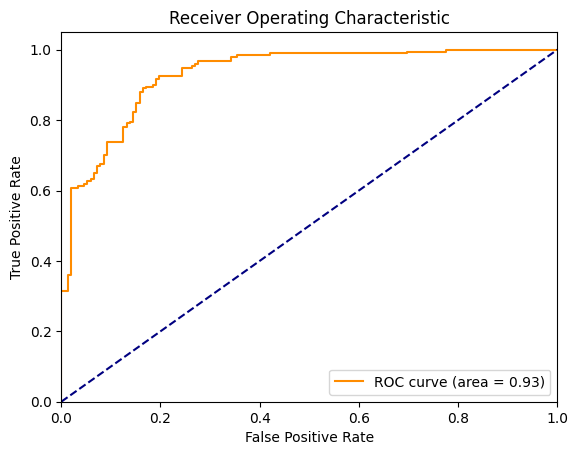

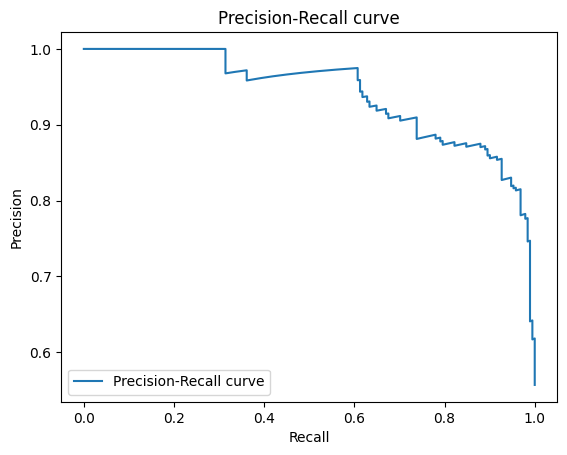

Accuracy:  0.8658892128279884
F1 Score:  0.8814432989690723
AUC:  0.862117663268118
Precision:  0.868020304568528
Recall:  0.8952879581151832


In [ ]:
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve, auc


# 使用模型进行预测
y_pred = best_model.predict(X_test)

# 计算ROC曲线的各个点
fpr, tpr, _ = roc_curve(y_test, y_pred)

# 计算AUC
roc_auc = auc(fpr, tpr)

# 绘制ROC曲线
# ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


# 精确度-召回率曲线
# precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, y_pred)
plt.figure()
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc="lower left")
plt.show()


# 将预测结果二值化，即将预测结果转换为0或1
# Binarize the prediction result, that is, convert the prediction result to 0 or 1
y_pred = np.where(y_pred > 0.5, 1, 0)
# print("y_pred: ", y_pred)

# 计算准确率 accuracy
accuracy = accuracy_score(y_test, y_pred)

# 计算F1得分 f1
f1 = f1_score(y_test, y_pred)

# 计算AUC得分 auc
auc = roc_auc_score(y_test, y_pred)

# 计算精度 precision
precision = precision_score(y_test, y_pred)

# 计算召回率 recall
recall = recall_score(y_test, y_pred)

print("Accuracy: ", accuracy)
print("F1 Score: ", f1)
print("AUC: ", auc)
print("Precision: ", precision)
print("Recall: ", recall)
